# New Section

In [12]:
# Load the Kaggle Favorita sales dataset
df = pd.read_csv('train.csv', parse_dates=['date'])

# Display first few rows
print(df.head())


   id       date  store_nbr      family  sales  onpromotion
0   0 2013-01-01          1  AUTOMOTIVE    0.0            0
1   1 2013-01-01          1   BABY CARE    0.0            0
2   2 2013-01-01          1      BEAUTY    0.0            0
3   3 2013-01-01          1   BEVERAGES    0.0            0
4   4 2013-01-01          1       BOOKS    0.0            0


In [13]:
# Filter for one store and one product family (optional)
df = df[(df['store_nbr'] == 1) & (df['family'] == 'GROCERY I')]

# Now aggregate sales by date
daily_sales = df.groupby('date')['sales'].sum().reset_index()


In [14]:
daily_sales = df.groupby('date')['sales'].sum().reset_index()


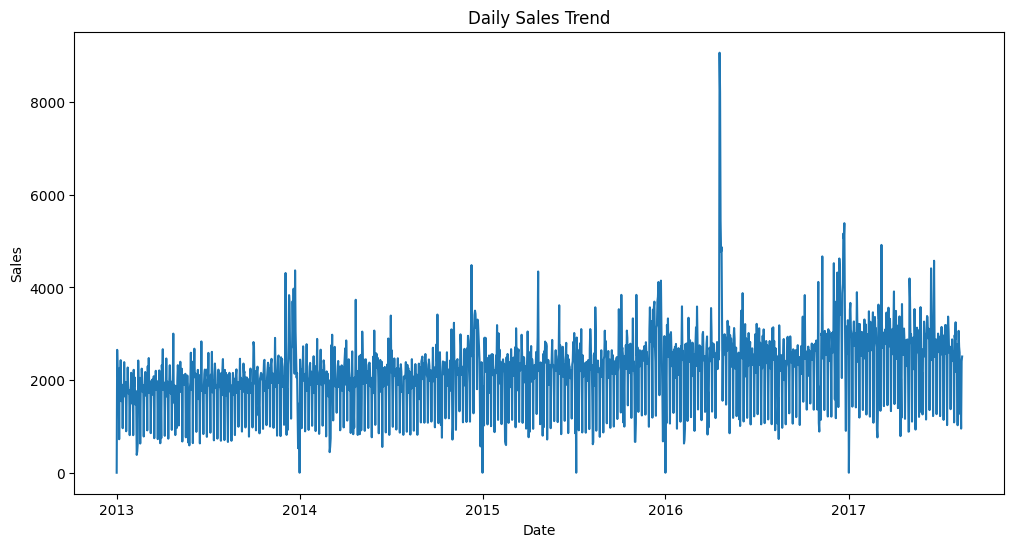

In [15]:
plt.figure(figsize=(12,6))
plt.plot(daily_sales['date'], daily_sales['sales'])
plt.title('Daily Sales Trend')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.show()


In [16]:
scaler = MinMaxScaler(feature_range=(0, 1))
daily_sales['scaled_sales'] = scaler.fit_transform(daily_sales[['sales']])


In [17]:
TIME_STEPS = 30

def create_sequences(data, time_steps):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i+time_steps])
        y.append(data[i+time_steps])
    return np.array(X), np.array(y)

X, y = create_sequences(daily_sales['scaled_sales'].values, TIME_STEPS)
X = X.reshape(X.shape[0], X.shape[1], 1)


In [18]:
split_index = int(0.8 * len(X))
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]


In [19]:
model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [20]:
history = model.fit(X_train, y_train, epochs=20, batch_size=16, validation_data=(X_test, y_test))


Epoch 1/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0261 - val_loss: 0.0103
Epoch 2/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0063 - val_loss: 0.0096
Epoch 3/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0061 - val_loss: 0.0089
Epoch 4/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0072 - val_loss: 0.0103
Epoch 5/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0070 - val_loss: 0.0085
Epoch 6/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0057 - val_loss: 0.0094
Epoch 7/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0065 - val_loss: 0.0086
Epoch 8/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0070 - val_loss: 0.0096
Epoch 9/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0067 - val_loss: 0.0097
Epoch 10/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0055 - val_loss: 0.0112
Epoch 11/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0061 - val_loss: 0.0087
Epoch 12/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0063 - val_

In [21]:
predictions_scaled = model.predict(X_test)
predictions = scaler.inverse_transform(predictions_scaled)
y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1,1))


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step


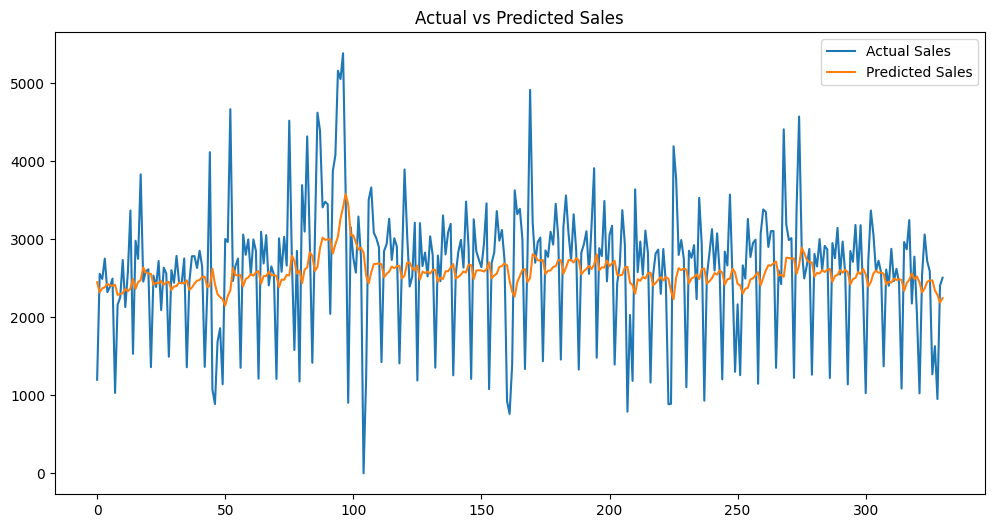

In [22]:
plt.figure(figsize=(12,6))
plt.plot(y_test_rescaled, label='Actual Sales')
plt.plot(predictions, label='Predicted Sales')
plt.legend()
plt.title('Actual vs Predicted Sales')
plt.show()


In [23]:
last_sequence = daily_sales['scaled_sales'].values[-TIME_STEPS:]
last_sequence = last_sequence.reshape((1, TIME_STEPS, 1))
next_day_scaled = model.predict(last_sequence)
next_day_sales = scaler.inverse_transform(next_day_scaled)[0][0]

stock_threshold = 500  # Set your threshold here

if next_day_sales > stock_threshold:
    print(f"⚠️ ALERT: Predicted sales ({next_day_sales:.2f}) exceed stock threshold. Restock needed.")
else:
    print(f"✅ Stock level sufficient. Predicted sales: {next_day_sales:.2f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
⚠️ ALERT: Predicted sales (2282.82) exceed stock threshold. Restock needed.
